Q: For exposure time calculations, should we be using the (bright sky)/(nominal dark sky) ratio derived at 5000A (b spectrograph) or 6500A (r spectrograph)? 

In this notebook, I'll measure this sky ratio at 5000A and 6500A for the CMX sky data

In [1]:
import h5py
import numpy as np 
from scipy.signal import medfilt
from scipy.signal import medfilt2d
# -- astropy --
import astropy.units as u
# -- desihub --
import desisim.simexp
from desimodel.io import load_throughput

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['medfilt2dtex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
# read nominal dark sky surface brightness
wavemin = load_throughput('b').wavemin - 10.0
wavemax = load_throughput('z').wavemax + 10.0
wave = np.arange(round(wavemin, 1), wavemax, 0.8) * u.Angstrom

# Generate specsim config object for a given wavelength grid
config = desisim.simexp._specsim_config_for_wave(wave.to('Angstrom').value, dwave_out=0.8, specsim_config_file='desi')

In [4]:
nominal_surface_brightness_dict = config.load_table(config.atmosphere.sky, 'surface_brightness', as_dict=True)

In [5]:
# read sky surface brightnesses for CMX BGS exposures
fskies = h5py.File('/global/cfs/cdirs/desi/users/chahah/bgs_exp_coadd/sky_fibers.cmx.v1.hdf5', 'r')
skies = {}
for k in fskies.keys():
    skies[k] = fskies[k][...]
fskies.close()

In [6]:
iexp = 0
for k in skies.keys():
    if 'wave' not in k and 'sky_sb' not in k: 
        print(k, skies[k][iexp])

airmass 1.1512571061868668
date 20200303
expid 52932
exptime 500.0
mjd 58912.279591935
moon_alt 35.75607401747595
moon_ill 0.6481039742146547
moon_sep 35.12972492991239
spectrograph 6
sun_alt -61.1995594021475
sun_sep 121.91097816773487
tileid 70500
transp_max 0.9791855265784067
transp_min 0.8751343888393194
transparency 0.9304259523400431


(0.0, 10)

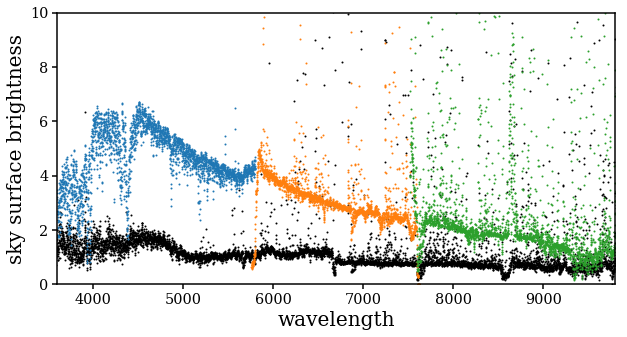

In [7]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(wave, nominal_surface_brightness_dict['dark'], c='k', s=1)
for band in ['b', 'r', 'z']: 
    sub.scatter(skies['wave_%s' % band], skies['sky_sb_%s' % band][iexp], s=1)
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylabel('sky surface brightness', fontsize=20)
sub.set_ylim(0., 10)

In [8]:
near5000 = (skies['wave_b'] > 4995) & (skies['wave_b'] < 5005)
near6500 = (skies['wave_r'] > 6495) & (skies['wave_r'] < 6505)

In [9]:
nom_near5000 = np.median(medfilt(nominal_surface_brightness_dict['dark'], 301)[(wave.value > 4995) & (wave.value < 5005)])
nom_near6500 = np.median(medfilt(nominal_surface_brightness_dict['dark'], 301)[(wave.value > 6495) & (wave.value < 6505)])

In [10]:
skies['sky_sb_b'].shape

(20773, 2751)

In [11]:
smooth_skies_b = medfilt2d(skies['sky_sb_b'], (1, 301))
smooth_skies_r = medfilt2d(skies['sky_sb_r'], (1, 301))

In [16]:
sky_ratio_b = np.median(smooth_skies_b[:,near5000], axis=1) / nom_near5000
sky_ratio_r = np.median(smooth_skies_r[:,near6500], axis=1) / nom_near6500

(0.0, 6)

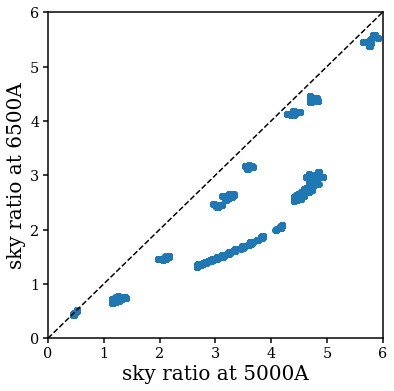

In [17]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(sky_ratio_b, sky_ratio_r)
sub.plot([0., 6.], [0., 6.], c='k', ls='--')
sub.set_xlabel('sky ratio at 5000A', fontsize=20)
sub.set_xlim(0., 6)
sub.set_ylabel('sky ratio at 6500A', fontsize=20)
sub.set_ylim(0., 6)

In [33]:
np.random.choice(np.unique(skies['expid'][sky_ratio_b > 3]), size=5)

array([55433, 55445, 52938, 52936, 53086])

In [18]:
#fskies = h5py.File('/global/cfs/cdirs/desi/users/chahah/bgs_exp_coadd/sky_fibers.cmx.v1.hdf5', 'a')
#fskies.create_dataset('sky_ratio_b', data=sky_ratio_b)
#fskies.create_dataset('sky_ratio_r', data=sky_ratio_r)
#fskies.close()